# Initial Researcher

This notebook demonstrates the research [workflow](https://langchain-ai.github.io/langgraph/tutorials/workflows/) that creates comprehensive reports through a series of focused steps. The system:

1. Uses a **graph workflow** with specialized nodes for each report creation stage
2. Enables user **feedback and approval** at critical planning points 
3. Produces a well-structured report with introduction, researched body sections, and conclusion


## Setup

Let's start by setting our directory and importing our environment variables

In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/Users/robertxu/Desktop/Projects/eng/open_deep_research/src


In [3]:
from dotenv import load_dotenv

load_dotenv("../.env")

True

Next, let's import all the helpers we'll need for implementation.

In [4]:
from agents.parallel.state import (
    ReportStateInput,
    ReportStateOutput,
    Sections,
    ReportState,
    SectionState,
    SectionOutputState,
    Queries,
    Feedback
)

from agents.parallel.prompts import (
    report_planner_query_writer_instructions,
    report_planner_instructions,
    query_writer_instructions, 
    section_writer_instructions,
    final_section_writer_instructions,
    section_grader_instructions,
    section_writer_inputs
)

from agents.parallel.configuration import Configuration
from agents.parallel.utils import (
    format_sections, 
    get_config_value, 
    get_search_params, 
    select_and_execute_search,
    get_today_str
)

## Implementation

### Nodes

#### Planner Module

First we'll create a node to generate the structure of our report. We'll load in all our configurations and first generate some web searches to inform our report structure. Based on the results, we'll generate a plan for our research to follow.

In [5]:
from langchain_core.runnables import RunnableConfig
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage


async def generate_report_plan(state: ReportState, config: RunnableConfig):
    """Generate the initial report plan with sections.
    
    This node:
    1. Gets configuration for the report structure and search parameters
    2. Generates search queries to gather context for planning
    3. Performs web searches using those queries
    4. Uses an LLM to generate a structured plan with sections
    
    Args:
        state: Current graph state containing the report topic
        config: Configuration for models, search APIs, etc.
        
    Returns:
        Dict containing the generated sections
    """

    # Inputs
    topic = state["topic"]

    # Get list of feedback on the report plan
    feedback_list = state.get("feedback_on_report_plan", [])

    # Concatenate feedback on the report plan into a single string
    feedback = " /// ".join(feedback_list) if feedback_list else ""

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    report_structure = configurable.report_structure
    number_of_queries = configurable.number_of_queries
    search_api = get_config_value(configurable.search_api)
    search_api_config = configurable.search_api_config or {}  # Get the config dict, default to empty
    params_to_pass = get_search_params(search_api, search_api_config)  # Filter parameters

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Set writer model (model used for query writing)
    writer_provider = get_config_value(configurable.writer_provider)
    writer_model_name = get_config_value(configurable.writer_model)
    writer_model_kwargs = get_config_value(configurable.writer_model_kwargs or {})
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider, model_kwargs=writer_model_kwargs) 
    structured_llm = writer_model.with_structured_output(Queries)

    # Format system instructions
    system_instructions_query = report_planner_query_writer_instructions.format(
        topic=topic,
        report_organization=report_structure,
        number_of_queries=number_of_queries,
        today=get_today_str()
    )

    # Generate queries  
    results = await structured_llm.ainvoke([SystemMessage(content=system_instructions_query),
                                     HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])

    # Web search
    query_list = [query.search_query for query in results.queries]

    # Search the web with parameters
    source_str = await select_and_execute_search(search_api, query_list, params_to_pass)

    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str, feedback=feedback)

    # Set the planner
    planner_provider = get_config_value(configurable.planner_provider)
    planner_model = get_config_value(configurable.planner_model)
    planner_model_kwargs = get_config_value(configurable.planner_model_kwargs or {})

    # Report planner instructions
    planner_message = """Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. 
                        Each section must have: name, description, research, and content fields."""

    # Run the planner
    if planner_model == "claude-3-7-sonnet-latest":
        # Allocate a thinking budget for claude-3-7-sonnet-latest as the planner model
        planner_llm = init_chat_model(model=planner_model, 
                                      model_provider=planner_provider, 
                                      max_tokens=20_000, 
                                      thinking={"type": "enabled", "budget_tokens": 16_000})

    else:
        # With other models, thinking tokens are not specifically allocated
        planner_llm = init_chat_model(model=planner_model, 
                                      model_provider=planner_provider,
                                      model_kwargs=planner_model_kwargs)
    
    # Generate the report sections
    structured_llm = planner_llm.with_structured_output(Sections)
    report_sections = await structured_llm.ainvoke([SystemMessage(content=system_instructions_sections),
                                             HumanMessage(content=planner_message)])

    # Get sections
    sections = report_sections.sections

    return {"sections": sections}



Next, we'll have the human review our research plan to ensure that the structure looks logical and appropriate for the task.

In [6]:
from typing import Literal

from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt, Command, Send


def human_feedback(state: ReportState, config: RunnableConfig) -> Command[Literal["generate_report_plan","build_section_with_web_research"]]:
    """Get human feedback on the report plan and route to next steps.
    
    This node:
    1. Formats the current report plan for human review
    2. Gets feedback via an interrupt
    3. Routes to either:
       - Section writing if plan is approved
       - Plan regeneration if feedback is provided
    
    Args:
        state: Current graph state with sections to review
        config: Configuration for the workflow
        
    Returns:
        Command to either regenerate plan or start section writing
    """

    # Get sections
    topic = state["topic"]
    sections = state['sections']
    sections_str = "\n\n".join(
        f"Section: {section.name}\n"
        f"Description: {section.description}\n"
        f"Research needed: {'Yes' if section.research else 'No'}\n"
        for section in sections
    )

    # Get feedback on the report plan from interrupt
    interrupt_message = f"""Please provide feedback on the following report plan. 
                        \n\n{sections_str}\n
                        \nDoes the report plan meet your needs?\nPass 'true' to approve the report plan.\nOr, provide feedback to regenerate the report plan:"""
    
    feedback = interrupt(interrupt_message)

    # If the user approves the report plan, kick off section writing
    if isinstance(feedback, bool) and feedback is True:
        # Treat this as approve and kick off section writing
        return Command(goto=[
            Send("build_section_with_web_research", {"topic": topic, "section": s, "search_iterations": 0}) 
            for s in sections 
            if s.research
        ])
    
    # If the user provides feedback, regenerate the report plan 
    elif isinstance(feedback, str):
        # Treat this as feedback and append it to the existing list
        return Command(goto="generate_report_plan", 
                       update={"feedback_on_report_plan": [feedback]})
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")

#### Researcher Module

We'll define a small subagent to generate web queries to research a given section determined by our report structure.

In [7]:
from langgraph.graph import START, END, StateGraph

async def generate_queries(state: SectionState, config: RunnableConfig):
    """Generate search queries for researching a specific section.
    
    This node uses an LLM to generate targeted search queries based on the 
    section topic and description.
    
    Args:
        state: Current state containing section details
        config: Configuration including number of queries to generate
        
    Returns:
        Dict containing the generated search queries
    """

    # Get state 
    topic = state["topic"]
    section = state["section"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    number_of_queries = configurable.number_of_queries

    # Generate queries 
    writer_provider = get_config_value(configurable.writer_provider)
    writer_model_name = get_config_value(configurable.writer_model)
    writer_model_kwargs = get_config_value(configurable.writer_model_kwargs or {})
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider, model_kwargs=writer_model_kwargs) 
    structured_llm = writer_model.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(topic=topic, 
                                                           section_topic=section.description, 
                                                           number_of_queries=number_of_queries,
                                                           today=get_today_str())

    # Generate queries  
    queries = await structured_llm.ainvoke([SystemMessage(content=system_instructions),
                                     HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState, config: RunnableConfig):
    """Execute web searches for the section queries.
    
    This node:
    1. Takes the generated queries
    2. Executes searches using configured search API
    3. Formats results into usable context
    
    Args:
        state: Current state with search queries
        config: Search API configuration
        
    Returns:
        Dict with search results and updated iteration count
    """

    # Get state
    search_queries = state["search_queries"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    search_api = get_config_value(configurable.search_api)
    search_api_config = configurable.search_api_config or {}  # Get the config dict, default to empty
    params_to_pass = get_search_params(search_api, search_api_config)  # Filter parameters

    # Web search
    query_list = [query.search_query for query in search_queries]

    # Search the web with parameters
    source_str = await select_and_execute_search(search_api, query_list, params_to_pass)

    return {"source_str": source_str, "search_iterations": state["search_iterations"] + 1}

async def write_section(state: SectionState, config: RunnableConfig) -> Command[Literal[END, "search_web"]]:
    """Write a section of the report and evaluate if more research is needed.
    
    This node:
    1. Writes section content using search results
    2. Evaluates the quality of the section
    3. Either:
       - Completes the section if quality passes
       - Triggers more research if quality fails
    
    Args:
        state: Current state with search results and section info
        config: Configuration for writing and evaluation
        
    Returns:
        Command to either complete section or do more research
    """

    # Get state 
    topic = state["topic"]
    section = state["section"]
    source_str = state["source_str"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)

    # Format system instructions
    section_writer_inputs_formatted = section_writer_inputs.format(topic=topic, 
                                                             section_name=section.name, 
                                                             section_topic=section.description, 
                                                             context=source_str, 
                                                             section_content=section.content)

    # Generate section  
    writer_provider = get_config_value(configurable.writer_provider)
    writer_model_name = get_config_value(configurable.writer_model)
    writer_model_kwargs = get_config_value(configurable.writer_model_kwargs or {})
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider, model_kwargs=writer_model_kwargs) 

    section_content = await writer_model.ainvoke([SystemMessage(content=section_writer_instructions),
                                           HumanMessage(content=section_writer_inputs_formatted)])
    
    # Write content to the section object  
    section.content = section_content.content

    # Grade prompt 
    section_grader_message = ("Grade the report and consider follow-up questions for missing information. "
                              "If the grade is 'pass', return empty strings for all follow-up queries. "
                              "If the grade is 'fail', provide specific search queries to gather missing information.")
    
    section_grader_instructions_formatted = section_grader_instructions.format(topic=topic, 
                                                                               section_topic=section.description,
                                                                               section=section.content, 
                                                                               number_of_follow_up_queries=configurable.number_of_queries)

    # Use planner model for reflection
    planner_provider = get_config_value(configurable.planner_provider)
    planner_model = get_config_value(configurable.planner_model)
    planner_model_kwargs = get_config_value(configurable.planner_model_kwargs or {})

    if planner_model == "claude-3-7-sonnet-latest":
        # Allocate a thinking budget for claude-3-7-sonnet-latest as the planner model
        reflection_model = init_chat_model(model=planner_model, 
                                           model_provider=planner_provider, 
                                           max_tokens=20_000, 
                                           thinking={"type": "enabled", "budget_tokens": 16_000}).with_structured_output(Feedback)
    else:
        reflection_model = init_chat_model(model=planner_model, 
                                           model_provider=planner_provider, model_kwargs=planner_model_kwargs).with_structured_output(Feedback)
    # Generate feedback
    feedback = await reflection_model.ainvoke([SystemMessage(content=section_grader_instructions_formatted),
                                        HumanMessage(content=section_grader_message)])

    # If the section is passing or the max search depth is reached, publish the section to completed sections 
    if feedback.grade == "pass" or state["search_iterations"] >= configurable.max_search_depth:
        # Publish the section to completed sections 
        update = {"completed_sections": [section]}
        if configurable.include_source_str:
            update["source_str"] = source_str
        return Command(update=update, goto=END)

    # Update the existing section with new content and update search queries
    else:
        return Command(
            update={"search_queries": feedback.follow_up_queries, "section": section},
            goto="search_web"
        )

#### Summarizer Module

We'll finish our implementation by creating a module for summarizing and compressing all the returned research. 

In [8]:
async def write_final_sections(state: SectionState, config: RunnableConfig):
    """Write sections that don't require research using completed sections as context.
    
    This node handles sections like conclusions or summaries that build on
    the researched sections rather than requiring direct research.
    
    Args:
        state: Current state with completed sections as context
        config: Configuration for the writing model
        
    Returns:
        Dict containing the newly written section
    """

    # Get configuration
    configurable = Configuration.from_runnable_config(config)

    # Get state 
    topic = state["topic"]
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    
    # Format system instructions
    system_instructions = final_section_writer_instructions.format(topic=topic, section_name=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section  
    writer_provider = get_config_value(configurable.writer_provider)
    writer_model_name = get_config_value(configurable.writer_model)
    writer_model_kwargs = get_config_value(configurable.writer_model_kwargs or {})
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider, model_kwargs=writer_model_kwargs) 
    
    section_content = await writer_model.ainvoke([SystemMessage(content=system_instructions),
                                           HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to section 
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """Format completed sections as context for writing final sections.
    
    This node takes all completed research sections and formats them into
    a single context string for writing summary sections.
    
    Args:
        state: Current state with completed sections
        
    Returns:
        Dict with formatted sections as context
    """

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def compile_final_report(state: ReportState, config: RunnableConfig):
    """Compile all sections into the final report.
    
    This node:
    1. Gets all completed sections
    2. Orders them according to original plan
    3. Combines them into the final report
    
    Args:
        state: Current state with all completed sections
        
    Returns:
        Dict containing the complete report
    """

    # Get configuration
    configurable = Configuration.from_runnable_config(config)

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    if configurable.include_source_str:
        return {"final_report": all_sections, "source_str": state["source_str"]}
    else:
        return {"final_report": all_sections}

### Edges

We'll use a conditional edge to determine when to initiate the final compilation of all report sections.

In [9]:
def initiate_final_section_writing(state: ReportState):
    """Create parallel tasks for writing non-research sections.
    
    This edge function identifies sections that don't need research and
    creates parallel writing tasks for each one.
    
    Args:
        state: Current state with all sections and research context
        
    Returns:
        List of Send commands for parallel section writing
    """

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"topic": state["topic"], "section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

## Final Graph

We'll first put together the researcher submodule responsible for researching individual sections of our report.

In [10]:
# Add nodes 
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

# Add edges
section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")


/var/folders/jj/2fvdkyfj0856p6_6sdvv74rw0000gn/T/ipykernel_90342/1617226580.py:2: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  section_builder = StateGraph(SectionState, output=SectionOutputState)


We'll then connect the researcher submodule to the planner submodule and summarize modules, creating a linear workflow to handle research tasks.

In [11]:
from langgraph.checkpoint.memory import MemorySaver
# Outer graph for initial report plan compiling results from each section -- 
# Add nodes
builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput, config_schema=Configuration)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("human_feedback", human_feedback)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

# Add edges
builder.add_edge(START, "generate_report_plan")
builder.add_edge("generate_report_plan", "human_feedback")
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

/var/folders/jj/2fvdkyfj0856p6_6sdvv74rw0000gn/T/ipykernel_90342/956734853.py:4: LangGraphDeprecatedSinceV10: `config_schema` is deprecated and will be removed. Please use `context_schema` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput, config_schema=Configuration)
/var/folders/jj/2fvdkyfj0856p6_6sdvv74rw0000gn/T/ipykernel_90342/956734853.py:4: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput, config_schema=Configuration)
/var/folders/jj/2fvdkyfj0856p6_6sdvv74rw0000gn/T/ipykernel_90342/956734853.py:4: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(ReportState, in

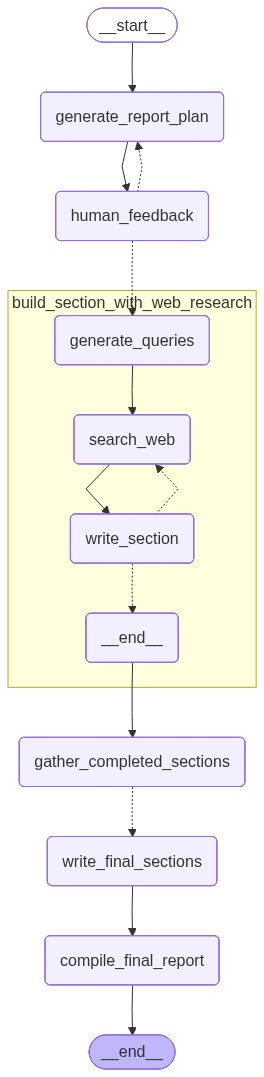

In [12]:
from IPython.display import Image, display, Markdown
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Running our Researcher

We can run our agent using the code sections below. NOTE that it does take several minutes to run, and consumes a large amount of tokens. 

As such, we've also included a sample trace of a successful run.

> Note: our agent has a human feedback step, so we've included traces for pre-feedback and post-feedback below

**Pre-feedback Public Trace**: https://smith.langchain.com/public/c7046da2-d7ac-4ae1-8783-08dc00e62fb5/r

**Post-feedback Public Trace**: https://smith.langchain.com/public/19b1afde-393b-4341-9e52-cfa1c2934b18/r

#### Configuring the Agent

In [14]:
import uuid
# Define report structure template and configure the research workflow
# This sets parameters for models, search tools, and report organization

REPORT_STRUCTURE = """Use this structure to create a report on the user-provided topic:

1. Introduction (no research needed)
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section should focus on a sub-topic of the user-provided topic
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the report"""

# Configuration: Use OpenAI o3 for both planning and writing (selected option)
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "openai",
                           "planner_model": "o3",
                           "writer_provider": "openai",
                           "writer_model": "o3",
                           "max_search_depth": 2,
                           "report_structure": REPORT_STRUCTURE,
                           }}

# Define research topic about Model Context Protocol
topic = "Overview of Model Context Protocol (MCP), an Anthropic‑backed open standard for integrating external context and tools with LLMs. Give an architectural overview for developers, tell me about interesting MCP servers, and compare to google Agent2Agent (A2A) protocol."

# Run the graph workflow until first interruption (waiting for user feedback)
async for event in graph.astream({"topic":topic,}, thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

Please provide feedback on the following report plan. 
                        

Section: Introduction
Description: Briefly orient the reader to the Model Context Protocol (MCP) and why it matters for integrating external context and tools with large-language-model applications.
Research needed: No


Section: MCP Architecture & Core Concepts
Description: Explain the client–server architecture, key primitives (tools, resources, prompts), transport options (stdio, HTTP/SSE), security model, and typical request–response flow so developers understand how MCP works under the hood.
Research needed: Yes


Section: Notable MCP Servers & Implementation Patterns
Description: Survey interesting open-source or commercial MCP servers (e.g., Filesystem, Git, Apify, AWS, Smithery catalog) and show code/config snippets illustrating how developers build or connect to these servers in apps like Claude Desktop or Cursor IDE.
Research needed: Yes


Section: MCP vs. Google Agent2Agent (A2A) Protocol
Description: Compare goals, data models, transport layers, discovery mechanisms, state management, and ideal use cases; highlight how MCP’s agent-to-tool focus complements A2A’s agent-to-agent collaboration.
Research needed: Yes


Section: Conclusion & Key Takeaways
Description: Summarize the main insights and provide a concise table or bullet list distilling differences, architectural highlights, and practical next steps for developers.
Research needed: No


                        
Does the report plan meet your needs?
Pass 'true' to approve the report plan.
Or, provide feedback to regenerate the report plan:

#### Applying User Feedback

In [15]:
# Submit feedback on the report plan
# The system will continue execution with the updated requirements

# Provide specific feedback to focus and refine the report structure
async for event in graph.astream(Command(resume="Looks great! Just do one section related to Agent2Agent (A2A) protocol, introducing it and comparing to MCP."), thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

Please provide feedback on the following report plan. 
                        

Section: Introduction
Description: Briefly introduces the Model Context Protocol (MCP), its purpose in integrating external context and tools with LLMs, and outlines what the report will cover.
Research needed: No


Section: MCP Architecture & Core Concepts
Description: Explains MCP’s host-client-server model, key primitives (resources, tools, prompts), message types (requests, results, notifications, errors), supported transports (stdio, HTTP/SSE), and security considerations so developers grasp the protocol’s building blocks.
Research needed: Yes


Section: Implementing MCP: Developer Workflow & SDKs
Description: Details how developers build or consume MCP servers/clients, including available SDKs (Python, TypeScript, Java, Kotlin), local vs. remote deployment patterns, configuration in apps like Claude Desktop, and illustrative code snippets.
Research needed: Yes


Section: Ecosystem Snapshot: Notable MCP Servers
Description: Surveys interesting open-source and commercial MCP servers (e.g., GitHub PR review, Filesystem, Postgres, Slack, Apify, Web Search) and categorizes them by function to show practical utility and integration patterns.
Research needed: Yes


Section: MCP vs. Google Agent-to-Agent (A2A) Protocol
Description: Introduces Google’s A2A protocol and provides a focused comparison with MCP across architecture, standardization, interoperability, and use-case fit, highlighting when developers might choose one over the other.
Research needed: Yes


Section: Conclusion
Description: Summarizes key insights and presents a concise table distilling architectural differences, implementation tips, and ecosystem highlights discussed in the report.
Research needed: No


                        
Does the report plan meet your needs?
Pass 'true' to approve the report plan.
Or, provide feedback to regenerate the report plan:

#### Content Generation 

In [16]:
# Approve the final plan and execute the report generation
# This triggers the research and writing phases for all sections

# The system will now:
# 1. Research each section topic
# 2. Generate content with citations
# 3. Create introduction and conclusion
# 4. Compile the final report

async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
    print(event)
    print("\n")

{'human_feedback': None}


{'build_section_with_web_research': {'completed_sections': [Section(name='Ecosystem Snapshot: Notable MCP Servers', description='Surveys interesting open-source and commercial MCP servers (e.g., GitHub PR review, Filesystem, Postgres, Slack, Apify, Web Search) and categorizes them by function to show practical utility and integration patterns.', research=True, content='## Ecosystem Snapshot: Notable MCP Servers  \n\nThe public registry already spans hundreds of servers, but a few “work-horse” groups dominate day-to-day agent workflows.  \n\n• Version control: the official GitHub server exposes 70+ tools for pull-request review, workflow logs and issue triage, making code automation a popular first MCP use-case [1].  \n\n• Databases: reference Postgres, BigQuery and Fireproof servers let assistants run safe SQL, inspect schema and even tune indexes, demonstrating a clear pattern—read-only by default with opt-in writes for production safety [1].  \n\n• Communic

Let's get the final result!

In [17]:
# Display the final generated report
# Retrieve the completed report from the graph's state and format it for display

final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Introduction

Large language models keep improving, yet they still need safe, structured ways to reach code, data, and other agents. The Model Context Protocol (MCP), backed by Anthropic, answers this need by giving hosts, clients, and servers a shared JSON-RPC language for exposing tools, resources, and prompts. This report explains MCP’s architecture and security model, walks through developer workflows and cross-language SDKs, surveys notable servers from GitHub to Apify, and contrasts MCP with Google’s Agent-to-Agent protocol so builders can pick the right standard.

## MCP Architecture & Core Concepts

MCP follows a three-tier “host → client → server” pattern. The host application (IDE, chatbot, agent) spawns one client per server; each client maintains a stateful, JSON-RPC session with its paired server, turning the old M×N integration maze into a simple M+N graph [1].

Servers advertise three primitives during the handshake:  
• Tools – callable functions the model may trigger (model-controlled).  
• Resources – read-only data the application decides to inject (app-controlled).  
• Prompts – reusable templates the user can pick (user-controlled) [1][2].

All traffic uses JSON-RPC 2.0. Four message flavours keep the dialogue clear: requests, successful results, notifications (one-way), and error responses. A session begins with an initialize request, capability negotiation, then normal operation until either side closes the transport [2][3].

Two transports are standard. Stdio is fastest for local child processes; Streamable HTTP with optional Server-Sent Events lets remote servers push incremental results over a single connection [1][3].

Security is handled in layers: fine-grained capability declarations restrict what each side may do; hosts must obtain explicit user consent before sharing data, invoking tools, or granting LLM sampling, and OAuth 2.1 is recommended for authenticating remote HTTP servers [2].

### Sources  
[1] Model Context Protocol (MCP) an overview: https://www.philschmid.de/mcp-introduction  
[2] The Model Context Protocol (MCP) — A Complete Tutorial: https://medium.com/@nimritakoul01/the-model-context-protocol-mcp-a-complete-tutorial-a3abe8a7f4ef  
[3] Architecture overview – Model Context Protocol: https://modelcontextprotocol.io/docs/learn/architecture

## Implementing MCP: Developer Workflow & SDKs

Official SDKs exist for Python, TypeScript, Java, Kotlin, C#, Go, Swift and more, all published in the modelcontextprotocol org and exposing the same JSON-RPC primitives [1].  

Typical workflow  
1 ) Install the SDK (`pip install fastmcp`, `npm i @modelcontextprotocol/sdk`, etc.).  
2 ) Describe Resources and Tools in code.  
3 ) Run the server with a local or remote transport.

```python
from fastmcp import FastMCP
mcp = FastMCP("Demo")

@mcp.resource("article://{id}")      # read-only context
def article(id: str) -> str: …

@mcp.tool()                          # callable action
def add(a: int, b: int) -> int: return a + b

mcp.run(transport="stdio")           # local pipe
``` [2]

Deployment patterns  
• Local: `stdio` launches the server as a child process; hosts such as Claude Desktop automatically open the pipe. Point the app at your binary by editing `claude_desktop_config.json` (`"command": "/path/to/server"`) [3].  
• Remote: switch to the single-endpoint “Streamable HTTP” transport for cloud or container use; it supersedes the older dual-channel SSE model and works cleanly behind load-balancers [3].

Because the transports are interchangeable, moving from a laptop prototype to a production micro-service is often a one-line change (`transport="streamhttp"` or `WithHttpTransport()`), while MCP clients continue to auto-discover your tools and resources unchanged.

### Sources
[1] Model Context Protocol Servers README: https://github.com/modelcontextprotocol/servers  
[2] The Only Guide You Will Ever Need For Model Context Protocol: https://www.analyticsvidhya.com/blog/2025/07/model-context-protocol-mcp-guide/  
[3] Building MCP Servers for Any Language: https://dev.to/yigit-konur/building-mcp-servers-for-any-language-including-kotlin-ruby-rust-java-go-typescript--2ofi

## Ecosystem Snapshot: Notable MCP Servers  

The public registry already spans hundreds of servers, but a few “work-horse” groups dominate day-to-day agent workflows.  

• Version control: the official GitHub server exposes 70+ tools for pull-request review, workflow logs and issue triage, making code automation a popular first MCP use-case [1].  

• Databases: reference Postgres, BigQuery and Fireproof servers let assistants run safe SQL, inspect schema and even tune indexes, demonstrating a clear pattern—read-only by default with opt-in writes for production safety [1].  

• Communication: the Slack server turns channels, DMs and searches into callable tools, allowing an agent to summarise or reply inside team chat without custom bots [1].  

• Web search & scraping: Exa’s server provides real-time search APIs, while Apify’s Actors server exposes 6 000+ web-automation micro-apps through a single MCP endpoint, giving agents broad reach with one integration [1][2].  

• Local context: the core Filesystem server delivers sandboxed read/write access to chosen folders, illustrating how hosts can supply private context without leaving the machine [3].  

Across categories, servers follow the same pattern—declare tools/prompts, speak JSON-RPC over stdio or SSE, and rely on the host to enforce consent—making them easy to mix-and-match in production stacks.  

### Sources  
[1] Awesome MCP Servers registry: https://www.codebolt.ai/registry/mcp-tools/385/  
[2] Apify blog – “The state of MCP”: https://blog.apify.com/what-is-model-context-protocol/  
[3] modelcontextprotocol/servers reference repo: https://github.com/modelcontextprotocol/servers

## MCP vs. Google Agent-to-Agent (A2A) Protocol  

Google’s A2A protocol lets autonomous agents talk as peers. It rides on familiar web tech—HTTP(S) plus JSON-RPC or gRPC, optional Server-Sent Events—and adds “Agent Cards” for capability discovery and a task lifecycle that supports streaming updates and long-running work [1]. The design assumes each agent hides its internals yet must negotiate formats, share artifacts, and update status securely across company boundaries.  

MCP tackles a different layer. It standardizes how one model or agent invokes **tools**—APIs, databases, file systems—through typed schemas that feel like function calls, giving the model a single, structured port to external resources [2]. Think of MCP as tool wiring, not peer dialogue.  

Comparison:  
• Architecture—A2A = agent-to-agent, stateful conversation; MCP = agent-to-tool, stateless calls.  
• Standardization—A2A defines discovery, security, and task states; MCP defines JSON schemas for tool inputs/outputs.  
• Interoperability—A2A bridges agents from any vendor; MCP solves the N × M problem of models versus APIs.  

Choose MCP when one LLM needs safe, repeatable access to internal systems. Choose A2A when several specialized agents must divide work, stream progress, and present a unified answer—often using MCP internally for their own tool calls [3].  

### Sources  
[1] Agent2Agent Protocol Official Specification: https://a2a-protocol.org/latest/specification/  
[2] A2A ❤️ MCP: Complementary Protocols for Agentic Systems: https://a2a-protocol.org/latest/topics/a2a-and-mcp/  
[3] MCP vs. A2A – Descope Blog: https://www.descope.com/blog/post/mcp-vs-a2a

## Conclusion

MCP streamlines tool integration by collapsing the N × M tangle of APIs into a single, capability-negotiated pipe; its host → client → server triad, JSON-RPC framing, and pluggable stdio or StreamHTTP transports let developers expose GitHub PR review, Postgres, Slack, or Apify crawlers in minutes. Google’s A2A, meanwhile, focuses higher up the stack—wrapping whole agents behind “cards,” coordinating long-running tasks, and broadcasting progress. The matrix distills the decisive contrasts and practical takeaways.

| Aspect | MCP | A2A |
| --- | --- | --- |
| Layer focus | Model/agent ↔︎ tool call | Agent ↔︎ agent collaboration |
| Session pattern | Stateful JSON-RPC; stateless tool invocations | Task lifecycle with streaming status |
| Discovery artifact | initialize handshake (tools, resources, prompts) | Agent Card (capabilities, auth) |
| Transport sweet spot | stdio for local, StreamHTTP for cloud | HTTP/gRPC + SSE across org boundaries |
| Example server | GitHub PR helper, Postgres SQL, Apify Actors | Research-agent delegating to summarizer agent |
| Dev tip | One-line swap between local and remote transports | Pair with MCP internally for tool calls |

Start by prototyping an MCP server over stdio, graduate to StreamHTTP in production, and layer A2A only when multiple specialized agents must negotiate tasks together.